# PySDDR: An Advanced Tutorial

In the beginner's guide only tabular data was used as input to the PySDDR framework. In this advanced tutorial we show the effects when combining structured and unstructured data. Currently, the framework only supports images as unstructured data.

We will use the MNIST dataset as a source for the unstructured data and generate additional tabular features corresponding to those. Our outcome in this tutorial is simulated based on linear and non-linear effects of tabular data and a linear effect of the number shown on the MNIST image. Our model is not provided with the (true) number, but instead has to learn the number effect from the image (together with the structured data effects):
\begin{equation*}
y = \sin(x_1) - 3x_2 + x_3^4 + 3\cdot number + \epsilon
\end{equation*}
with $\epsilon \sim \mathcal{N}(0, \sigma^2)$ and $number$ is the number on the MNIST image.

The aim of training is for the model to be able to output a latent effect, representing the number depicted in the MNIST image.

We start by importing the sddr module and other required libraries

In [ ]:
!pip install ..

In [1]:
# import the sddr module
from sddr import Sddr

import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


#set seeds for reproducibility
torch.manual_seed(1)
np.random.seed(1)

/home/scc/pa6512/miniconda3/lib/python3.12/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


### User inputs 

First the user defines the data to be used. The data is loaded and if it does not already exist, a column needs to be added to the tabular data describing the unstructured data - structured data correspondence. In the example below we add a column where each item includes the name of the image to which the current row of tabular data corresponds.

In [2]:
data_path = '../data/mnist_data/tab.csv'

data = pd.read_csv(data_path,delimiter=',')

# append a column for the numbers: each data point contains a file name of the corresponding image
for i in data.index:
    data.loc[i,'numbers'] = f'img_{i}.jpg'

In [5]:
data

,x1,x2,x3,y_gen,y_true,numbers
0,2.606303,-0.141809,0.053795,-11.283425,2,img_0.jpg
1,2.746226,-0.813898,0.753431,12.308747,9,img_1.jpg
2,-1.343725,-0.325541,0.249850,-8.534480,3,img_2.jpg
3,2.076264,0.378157,-0.444105,-5.306146,4,img_3.jpg
4,0.890613,-1.994485,-0.050270,-10.098662,0,img_4.jpg
...,...,...,...,...,...,...
7995,-2.771807,0.670894,0.611563,-0.159374,7,img_7995.jpg
7996,1.900410,-0.998891,0.207087,9.028810,7,img_7996.jpg
7997,-0.305296,0.377886,0.535751,0.410818,7,img_7997.jpg
7998,-0.995108,-0.223575,1.437215,-6.987264,3,img_7998.jpg


In [6]:
np.ptp(np.sin(data['x1']))

1.9999997500628675

Next the distribution, formulas and training parameters are defined. The size of each image is ```28x28``` so our neural network has a layer which flattens the input, which is followed by a linear layer of input size ```28x28``` and an output size of ```128```. Finally, this is followed by a ```ReLU``` for the activation.

Here the structured data is not pre-loaded as it would be typically too large to load in one step. Therefore the path to the directory in which it is stored is provided along with the data type (for now only 'images' supported). The images are then loaded in batches using PyTorch's dataloader. Note that here again the key given in the ```unstructured_data``` dictionary must match the name it is given in the formula, in this case ```'numbers'```. Similarly the keys of the ```deep_models_dict``` must also match the names in the formula, in this case ```'dnn'```

In [3]:
# define distribution and the formula for the distibutional parameter
distribution  = 'Normal'

formulas = {'loc': '~ -1 + spline(x1, bs="bs", df=10) + x2 + dnn(numbers) + spline(x3, bs="bs", df=10)',
            'scale': '~1'
            }


# define the deep neural networks' architectures and output shapes used in the above formula
deep_models_dict = {
'dnn': {
    'model': nn.Sequential(nn.Flatten(1, -1),
                           nn.Linear(28*28,128),
                           nn.ReLU()),
    'output_shape': 128},
}

# define your training hyperparameters
train_parameters = {
    'batch_size': 8000,
    'epochs': 1000,
    'degrees_of_freedom': {'loc':9.6, 'scale':9.6},
    'optimizer' : optim.Adam,
    'val_split': 0.15,
    'early_stop_epsilon': 0.001,
    'dropout_rate': 0.01
}


# provide the location and datatype of the unstructured data
unstructured_data = {
  'numbers' : {
    'path' : '../data/mnist_data/mnist_images',
    'datatype' : 'image'
  }
}

# define output directory
output_dir = './outputs'


### Initialization

The sddr instance is initialized with the parameters given by the user in the previous step:

In [4]:
sddr = Sddr(output_dir=output_dir,
            distribution=distribution,
            formulas=formulas,
            deep_models_dict=deep_models_dict,
            train_parameters=train_parameters,
            modify=False
            )

Using device:  cpu


In [7]:
sddr

### Training

The sddr network is trained with the data defined above and the loss curve is plotted.

Beginning training ...
Train Epoch: 0 	 Training Loss: 129.044235
Train Epoch: 0 	 Validation Loss: 143.731430
Train Epoch: 100 	 Training Loss: 98.631737
Train Epoch: 100 	 Validation Loss: 118.444672
Train Epoch: 200 	 Training Loss: 72.725510
Train Epoch: 200 	 Validation Loss: 106.192207
Train Epoch: 300 	 Training Loss: 53.934399
Train Epoch: 300 	 Validation Loss: 97.589706
Train Epoch: 400 	 Training Loss: 40.977585
Train Epoch: 400 	 Validation Loss: 91.561447
Train Epoch: 500 	 Training Loss: 32.425842
Train Epoch: 500 	 Validation Loss: 86.033844
Train Epoch: 600 	 Training Loss: 26.020658
Train Epoch: 600 	 Validation Loss: 81.424416
Train Epoch: 700 	 Training Loss: 21.336876
Train Epoch: 700 	 Validation Loss: 77.051880
Train Epoch: 800 	 Training Loss: 17.973541
Train Epoch: 800 	 Validation Loss: 74.675018
Train Epoch: 900 	 Training Loss: 15.363472
Train Epoch: 900 	 Validation Loss: 71.651222


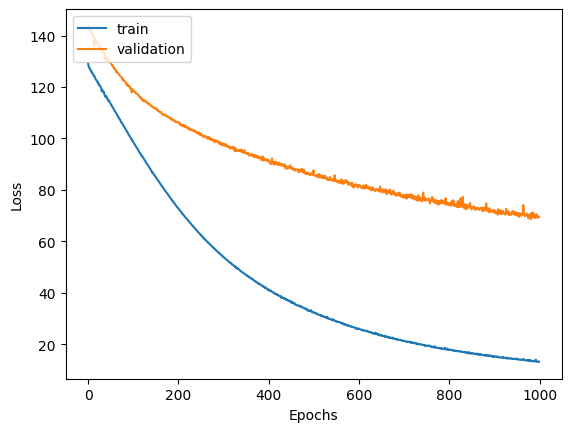

In [8]:
sddr.train(structured_data=data,
           target="y_gen",
           unstructured_data = unstructured_data,
           plot=True)

In [9]:
sddr.save("ssdr_advanced_tutorials.pth")

/scratch/ipykernel_3245244/1255580359.py:1: UserWarning: Please note that the metadata for the structured input has not been saved. If you want to load the model and use
        it on new data you will need to also give the structured data used for training as input to the load function.
  sddr.save("ssdr_advanced_tutorials.pth")


In [5]:
sddr.load("outputs/ssdr_advanced_tutorials.pth", data)
sddr.train(target="y_gen", structured_data=data, resume=True)

Loaded model outputs/ssdr_advanced_tutorials.pth at epoch 1000 with a validation loss of 69.6172
Beginning training ...


In [45]:
sddr.net.extra_repr()

''

In [53]:
net_loc = sddr.net.single_parameter_sddr_list['loc']

In [ ]:
deep_head_weights = net_loc.deep_head.weight

torch.Size([1, 128])

In [57]:
structured_head_weights = net_loc.structured_head.weight
structured_head_bias = net_loc.structured_head.bias

In [59]:
structured_head_weights.shape

torch.Size([1, 21])

In [60]:
structured_head_bias

In [ ]:
# Create a dictionary to store latent features for each deep model
latent_features = {}

def make_hook(name):
    def hook(module, input, output):
        latent_features[name] = output.detach()
    return hook

# Register hooks on each deep model in the deep_models_dict
hook_handles = []
for name, model in net_loc.deep_models_dict.items():
    h = model.register_forward_hook(make_hook(name))
    hook_handles.append(h)

# Prepare a sample input (make sure 'data_dict' is prepared according to your model)
# For example:
# data_dict = {
#     "structured": structured_input_tensor, 
#     "loc": deep_input_tensor_for_loc,  # plus additional keys if needed
#     ... 
# }

# Run a forward pass through net_loc (or directly net_loc for the "loc" branch)
_ = net_loc({"structured": sddr_data["structured"],
              "loc": sddr_data["loc"]}, training=False)

# At this point, latent_features will contain the outputs for each deep model.
print("Latent features (deep models):")
for name, features in latent_features.items():
    print(f"{name}: shape {features.shape}")

# Remove the hooks after use
for h in hook_handles:
    h.remove()

(Normal(loc: torch.Size([8000, 1]), scale: torch.Size([8000, 1])),
 {'loc': [(array([ 2.60630324,  2.74622581, -1.34372493, ..., -0.30529594,
           -0.99510831,  2.73718948]),
    array([-0.01231886, -0.02674322, -0.05867052, ..., -0.00270661,
           -0.04503903, -0.02579797], dtype=float32),
    array([-0.0125851 , -0.02715843, -0.05905215, ..., -0.00265951,
           -0.04532501, -0.026203  ]),
    array([-0.00805698, -0.01502311, -0.05640881, ..., -0.00265845,
           -0.04280683, -0.01471433]),
    array([-0.0125851 , -0.02715843, -0.05905215, ..., -0.00265845,
           -0.04532501, -0.026203  ]),
    array([-0.0125851 , -0.02715843, -0.05905215, ..., -0.00265845,
           -0.04532501, -0.026203  ])),
   (array([0.05379511, 0.75343075, 0.24985048, ..., 0.53575066, 1.43721528,
           1.30884905]),
    array([-0.16426979, -0.02983898, -0.13894872, ..., -0.08498804,
            0.1788552 ,  0.13857587], dtype=float32),
    array([-0.1659551 , -0.02998577, -0.14058

In [34]:
len(pred[1]['loc'])

2

In [38]:
len(pred[1]['loc'][0])

6

In [ ]:
sddr.coeff('loc')['spline(x1, bs="bs", df=10)']

array([-0.03699172, -0.04553132, -0.06530747, -0.06824484, -0.01498337,
        0.05458267,  0.07935693,  0.02893556, -0.0373396 , -0.06881794],
      dtype=float32)

In [29]:
sddr.prepare_data.dm_info_dict['loc']['non_spline_info']['list_of_non_spline_input_features']

[['x2']]

In [28]:
sddr.prepare_data.dm_info_dict['loc']['spline_info']['list_of_spline_input_features']

[['x1'], ['x3']]

In [8]:
sddr.prepare_data.dm_info_dict['loc']['non_spline_info']

{'list_of_non_spline_slices': [slice(10, 11, None),
  slice(0, 10, None),
  slice(11, 21, None)],
 'list_of_non_spline_input_features': [['x2']],
 'list_of_term_names': ['x2',
  'spline(x1, bs="bs", df=10)',
  'spline(x3, bs="bs", df=10)']}

In [12]:
spline_terms = sddr.prepare_data.dm_info_dict['loc']['spline_info']['list_of_term_names']

In [13]:
spline_terms

['spline(x1, bs="bs", df=10)', 'spline(x3, bs="bs", df=10)']

In [15]:
spline_terms = [sublist for sublist in spline_terms]

In [16]:
spline_terms

['spline(x1, bs="bs", df=10)', 'spline(x3, bs="bs", df=10)']

In [18]:
sddr.prepare_data.dm_info_dict['scale']

{'spline_info': {'list_of_spline_slices': [],
  'list_of_spline_input_features': [],
  'list_of_term_names': []},
 'non_spline_info': {'list_of_non_spline_slices': [slice(0, 1, None)],
  'list_of_non_spline_input_features': [[]],
  'list_of_term_names': ['Intercept']}}

In [18]:
sddr.coeff('loc')['x2'][0]

-0.3931892

In [10]:
true_nonlinear_effects = np.zeros((2, len(data)))
true_nonlinear_effects[0,:] = np.sin(data['x1'])
true_nonlinear_effects[1,:] = data['x3'] ** 4


In [11]:

degrees_of_freedom = {'loc':9.6, 'scale':9.6}
def plot_true_and_ci(sorted_feature, sorted_pred, sorted_ci950,
                    sorted_ci951, sorted_true_effect, param,
                    idx):
    """
    Plots the estimated partial effect with its 95% CI and overlays the true nonlinear effect.
    
    Parameters:
      - true_effect: 1D array of shape (n_samples,) for the true effect for this spline.
      - partial_effect: tuple (feature, pred, ci950, ci951, ci250, ci251) from ssdr.eval.
      - param: parameter name (e.g., 'loc' or 'scale' or 'rate').
      - spline_index: index of the current spline.
    """

    plt.figure(figsize=(8, 6))
    plt.plot(sorted_feature, sorted_pred, label="Estimated Partial Effect", color="blue")
    plt.fill_between(sorted_feature, sorted_ci950, sorted_ci951, color="blue", alpha=0.3, label="95% CI")
    plt.scatter(sorted_feature, sorted_true_effect, color="red", marker="x", label="True Nonlinear Effect")
    plt.title(f"Parameter: {param} - Spline {idx}")
    plt.xlabel("Feature")
    plt.ylabel("Effect")
    plt.legend()
    plt.show()

In [19]:
sorted_feature

array([-3.14009162, -3.13924602, -3.13918887, ...,  3.1399631 ,
        3.14010504,  3.14053233])

In [21]:
true_nonlinear_effects

0       0.510090
1       0.385147
2      -0.974330
3       0.874948
4       0.777458
          ...   
7995   -0.361416
7996    0.946168
7997   -0.300575
7998   -0.838818
7999    0.393470
Name: x1, Length: 8000, dtype: float64

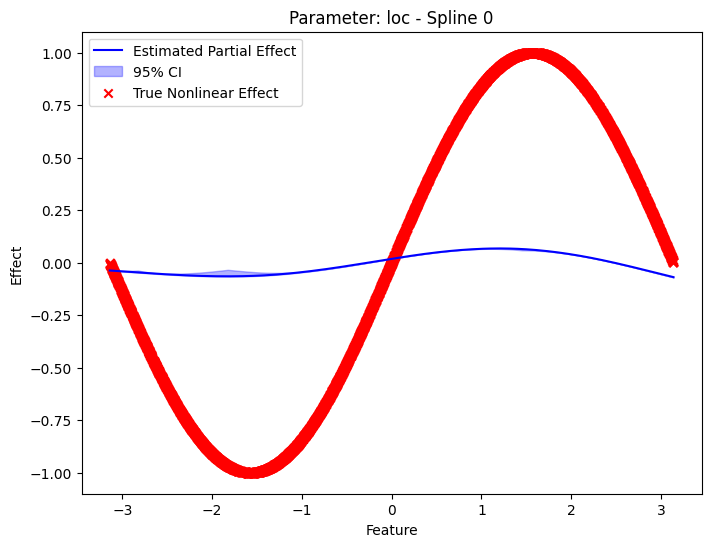

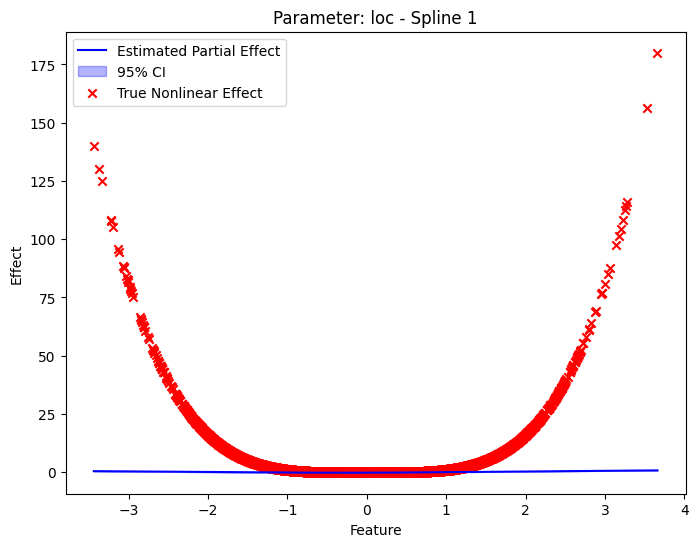

In [12]:
eval_dict = {}
for k in degrees_of_freedom.keys():
    eval_results = sddr.eval(k, plot=False)
    eval_dict[k] = eval_results

param_to_index = {"rate": 0, "loc": 0, "scale": 1}

# Compute coverage rates for each parameter.
coverage_rates = {}
for param, partial_effects in eval_dict.items():
    if len(partial_effects)>0:
        coverage_rates[param] = {}
        # For Gaussian (or gamma) cases, we assume true_nonlinear_effects is a dict with keys matching the parameter names.
        # For Poisson, true_nonlinear_effects is a list.
        true_effects = np.array(true_nonlinear_effects)
        for idx, effect in enumerate(partial_effects):
            if len(effect) == 6:
                feature, pred, ci950, ci951, _, _ = effect
                
                # Get the corresponding true effect for this spline; shape: (n_samples, )
                true_effect = true_effects[idx,:]
                # Sort both the feature and true effect to ensure proper alignment.
                sort_idx = np.argsort(feature)
                sorted_feature = np.array(feature)[sort_idx]
                sorted_pred = np.array(pred)[sort_idx]
                sorted_ci950 = ci950[sort_idx]
                sorted_ci951 = ci951[sort_idx]
                sorted_true_effect = true_effect[sort_idx]

                plot_true_and_ci(sorted_feature, sorted_pred, sorted_ci950,
                                    sorted_ci951, sorted_true_effect, param,
                                    idx)
                # Now compute coverage.
                covered = np.logical_and(sorted_true_effect >= sorted_ci950, sorted_true_effect <= sorted_ci951)
                # covered = np.logical_and(np.logical_and(true_effects >= ci950, true_effects <= ci951))
                # breakpoint()
                # print(covered)
                coverage_rate = np.mean(covered)
                coverage_rates[param][f'spline_{idx}'] = coverage_rate
            else:
                coverage_rates[param][f'spline_{idx}'] = None

In [24]:
print("Coverage rates for replicate:")
for param, cov_dict in coverage_rates.items():
    print(f"Parameter {param}:")
    for key, val in cov_dict.items():
        if val is not None:
            print(f"  {key}: {val:.2%}")
        else:
            print(f"  {key}: N/A")

Coverage rates for replicate:
Parameter loc:
  spline_0: 0.00%
  spline_1: 0.50%


In [25]:
sddr.coeff("loc")

{'x2': array([-0.3931892], dtype=float32),
 'spline(x1, bs="bs", df=10)': array([-0.03699172, -0.04553132, -0.06530747, -0.06824484, -0.01498337,
         0.05458267,  0.07935693,  0.02893556, -0.0373396 , -0.06881794],
       dtype=float32),
 'spline(x3, bs="bs", df=10)': array([ 0.4896934 ,  0.28971538, -0.00934109, -0.18045202, -0.18766662,
        -0.15186863, -0.07683007,  0.27471817,  0.6219222 ,  0.81320816],
       dtype=float32)}

In [20]:
sddr.dataset.get_list_of_feature_names()

['x1', 'x2', 'x3', 'y_true', 'numbers']

In [29]:
sddr.dataset.prepared_data.keys()

dict_keys(['loc', 'scale'])

In [32]:
print(sddr.dataset.prepared_data['loc'].keys())

dict_keys(['structured', 'dnn'])


In [35]:
sddr.dataset.prepared_data['loc']['structured'].shape # M

torch.Size([8000, 21])

In [39]:
sddr.dataset.prepared_data['loc']['structured']

tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 1.4356e-01, 1.2702e-03,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 1.6371e-01,  ..., 2.0761e-04, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 3.6128e-02, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 3.8173e-02,  ..., 4.8297e-01, 1.1941e-01,
         3.0102e-03],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 4.5218e-01, 8.0059e-02,
         8.5850e-04]])

In [40]:
sddr.dataset.prepared_data['scale']['structured'].shape

torch.Size([8000, 1])

In [ ]:
sddr.dataset.prepared_data['loc']['structured']

### Evaluation - Visualizing the partial effects

In this case the data is assumed to follow a normal distribution, in which case two distributional parameters, loc and scale, need to be estimated. Below we plot the partial effects of each smooth term.

Remember the partial effects are computed by: partial effect = smooth_features * coefs (weights)
In other words the smoothing terms are multiplied with the weights of the Structured Head. We use the partial effects to interpret whether our model has learned correctly.

In [5]:
partial_effects_loc = sddr.eval('loc',plot=True)

NameError: name 'sddr' is not defined

In [7]:
partial_effects_scale = sddr.eval('scale',plot=True)

Nothing to plot. No (non-)linear partial effects specified for this parameter. (Deep partial effects are not plotted.)


As we can see the distributional parameter loc has two parial effects, one sinusoidal and one quadratic. The parameter scale expectedly has no partial effect since the formula only includes an intercept.

Next we retrieve our ground truth data and compare it with the model's estimation

Predicted variance for first sample: tensor([1.3791])


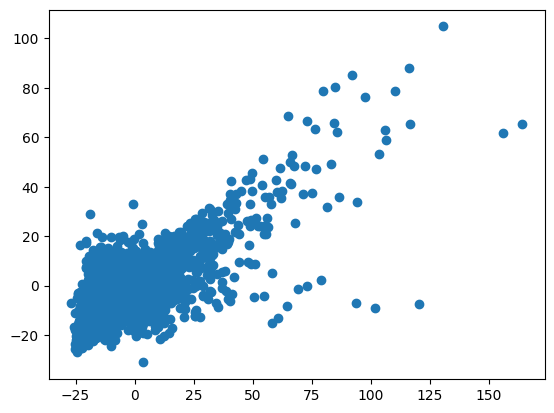

In [25]:
# compare prediction of neural network with ground truth
data_pred = data.loc[:,:]
ground_truth  = data.loc[:,'y_gen']

# predict returns partial effects and a distributional layer that gives statistical information about the prediction
distribution_layer, partial_effect = sddr.predict(data_pred,
                                                  clipping=True, 
                                                  plot=False, 
                                                  unstructured_data = unstructured_data)
# retrieve the mean and  variance of the distributional layer
predicted_mean = distribution_layer.loc[:,:].T
predicted_variance = distribution_layer.scale[0]

# and plot the result
plt.scatter(ground_truth, predicted_mean)
print(f"Predicted variance for first sample: {predicted_variance}")

The comparison shows that for most samples the predicted and true values are directly propotional.

Next we want to check if the model learned the correct correspondence of images and numbers

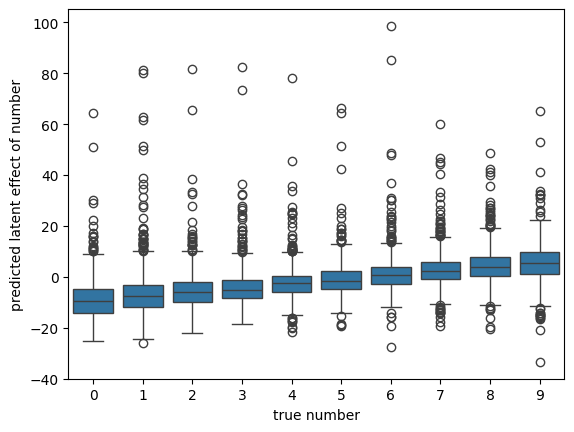

In [9]:
# we create a copy of our original structured data where we set all inputs but the images to be zero
data_pred_copy = data.copy()
data_pred_copy.loc[:,'x1'] = 0
data_pred_copy.loc[:,'x2'] = 0
data_pred_copy.loc[:,'x3'] = 0

# and make a prediction using only the images
distribution_layer, partial_effect = sddr.predict(data_pred_copy,
                                                  clipping=True, 
                                                  plot=False, 
                                                  unstructured_data = unstructured_data)
# add the predicted mean value to our tabular data
data_pred_copy['predicted_number'] = distribution_layer.loc[:,:].numpy().flatten()

# and compare the true number on the images with the predicted number
ax = sns.boxplot(x="y_true", y="predicted_number", data=data_pred_copy)

ax.set_xlabel("true number");
ax.set_ylabel("predicted latent effect of number");

Observing the boxplot figure we see that as the true values, i.e. numbers depicted on images, are increasing, so too are the medians of the predicted distributions. Therefore the partial effect of the neural network is directly correlated with the number depicted in the MNIST images, proving that our neural network, though simple, has learned from the unstructured data.